In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from torch_geometric.utils import from_networkx, to_networkx


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger



from typing import Callable, Optional

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor
from project.sheaf_datamodule import SheafDataset_ForGraphs, SheafDataModule_ForGraphs
from project.sheaf_learner import coboundary_learner_on_graph_signal

from project.sheaf_simultaneous_functor_edgewise  import sheaf_gradient_flow_functor

In [5]:
import wandb

In [6]:
wandb.login()

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


True

In [7]:
dataset = get_dataset('texas')
data = dataset[0]
data = get_fixed_splits(data, 'texas', 0)

In [8]:
graph = to_networkx(data)

In [9]:
mask = {'train_mask':data.train_mask, 
        'val_mask':data.val_mask, 
        'test_mask':data.test_mask
       }

In [10]:
sweep_config = {
    'method': 'random'
    }

In [11]:
metric = {
    'name': 'val_acc',
    'goal': 'maximize'   
    }
sweep_config['metric'] = metric

In [12]:
parameters_dict = {
    'dv': {
        'distribution': 'categorical',
        'values': [2,3,4,5]
    },
    'de': {
        'distribution': 'categorical',
        'values': [2,3,4,5]
    },
    'input_dropout': {
        'distribution': 'uniform',
        'min': 0.1,
        'max': 0.9
    },
    'dropout': {
        'distribution': 'uniform',
        'min': 0.1, 
        'max': 0.9
    },
    #'graph':{
    #    'value': graph,       
    #},
    
    #'mask':{
    #    'value': mask
    #},
    #'Nv':{
    #    'value': 183
    #},
    #'Ne':{
    #    'value': 558
    #},
    'layers':{
        'distribution': 'categorical',
        'values': [2,3,4]
    },
    'channels':{
        'distribution': 'categorical',
        'values': [2,3,4,5]
    },
    'batch_size':{
        'distribution': 'categorical',
        'values': [60]
    },
    #'input_dim':{ 'value': 1703},
    #'output_dim':{'value':5},
    #'left_weights':{'value':True},
    #'right_weights':{'value':True},
    #'potential':{'value':'radial'},
    #'use_act':{'value':True},
    #'augmented':{'value':True},
    #'add_lp':{'value':True},
    #'add_hp':{'value':True},
    'first_hidden':{
        'distribution':'categorical',
        'values':[1000, 500, 100]
    },
    'second_hidden':{
        'distribution':'categorical',
        'values':[1000, 500, 100]
    },
    
    'free_potential':{
        'distribution':'categorical',
        'values':[True, False]
    }
    
    
    
}

sweep_config['parameters'] = parameters_dict

In [13]:
import pprint

In [14]:
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_acc'},
 'parameters': {'batch_size': {'distribution': 'categorical', 'values': [60]},
                'channels': {'distribution': 'categorical',
                             'values': [2, 3, 4, 5]},
                'de': {'distribution': 'categorical', 'values': [2, 3, 4, 5]},
                'dropout': {'distribution': 'uniform', 'max': 0.9, 'min': 0.1},
                'dv': {'distribution': 'categorical', 'values': [2, 3, 4, 5]},
                'first_hidden': {'distribution': 'categorical',
                                 'values': [1000, 500, 100]},
                'free_potential': {'distribution': 'categorical',
                                   'values': [True, False]},
                'input_dropout': {'distribution': 'uniform',
                                  'max': 0.9,
                                  'min': 0.1},
                'layers': {'distribution': 'categorical', 'values': [2, 3, 4]},
         

In [15]:
sweep_id = wandb.sweep(sweep_config, project="Sweep_functor_Dec_14")

Create sweep with ID: 27a3vbiw
Sweep URL: https://wandb.ai/saepark/Sweep_functor_Dec_14/sweeps/27a3vbiw


In [16]:
early_stop_callback = EarlyStopping(monitor="val_acc", min_delta=0.01, patience=15, verbose=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_accuracy",
    dirpath="/root/projects/temp_checkpoints",
    filename="Functor-sweep-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}",
    save_top_k=8,
    mode="max",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [17]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger_diffusion = WandbLogger(project="Sweep_sheaf_learning_diffusion_with_coboundary_potential")

    # setup data
    sheaf_dm = SheafDataModule_ForGraphs(data, wandb.config.batch_size , 1)

    # setup model - note how we refer to sweep parameters with wandb.config
    model_diffusion = sheaf_gradient_flow_functor(graph, 183, wandb.config.dv, graph.number_of_edges(), wandb.config.de, wandb.config.layers, 1703,5, wandb.config.channels, True, True, 'radial', mask, True,True,True,True, wandb.config.dropout,wandb.config.input_dropout,True, wandb.config.first_hidden, wandb.config.second_hidden, 1e-4)

    #model_diffusion = sheaf_gradient_flow_potential(graph, 183, wandb.config.dv, graph.number_of_edges(), wandb.config.de, wandb.config.layers, 1703,5, wandb.config.channels, True, True, 'radial', mask, True,True,True,True, wandb.config.dropout,wandb.config.input_dropout, wandb.config.learning_rate)

    # setup Trainer
    #trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion,auto_lr_find=True)
    trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion)

    # train
    trainer.fit(model_diffusion, sheaf_dm)

In [18]:
wandb.agent(sweep_id, function=sweep_iteration)

wandb: Agent Starting Run: ue9bkj2n with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.24908962514006713
wandb: 	dv: 2
wandb: 	first_hidden: 500
wandb: 	free_potential: True
wandb: 	input_dropout: 0.6336811899720699
wandb: 	layers: 2
wandb: 	second_hidden: 500


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.52874
train_loss,1.20157
trainer/global_step,59
val_acc,0.52542


Run ue9bkj2n errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: ERROR Run ue9bkj2n errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kuv6i7ku with config:
wandb: 	batch_size: 60
wandb: 	channels: 4
wandb: 	de: 5
wandb: 	dropout: 0.25329006204143434
wandb: 	dv: 3
wandb: 	first_hidden: 1000
wandb: 	free_potential: True
wandb: 	input_dropout: 0.5820397641859126
wandb: 	layers: 2
wandb: 	second_hidden: 1000


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.37931
train_loss,1.4462
trainer/global_step,59
val_acc,0.52542


Run kuv6i7ku errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: ERROR Run kuv6i7ku errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: Agent Starting Run: ux8re878 with config:
wandb: 	batch_size: 60
wandb: 	channels: 5
wandb: 	de: 3
wandb: 	dropout: 0.22338891251869825
wandb: 	dv: 2
wandb: 	first_hidden: 100
wandb: 	free_potential: False
wandb: 	input_dropout: 0.4594563945213752
wandb: 	layers: 2
wandb: 	second_hidden: 1000


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.54023
train_loss,1.17373
trainer/global_step,59
val_acc,0.52542


Run ux8re878 errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: ERROR Run ux8re878 errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: Agent Starting Run: zqn061fo with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 4
wandb: 	dropout: 0.14015360066523402
wandb: 	dv: 2
wandb: 	first_hidden: 100
wandb: 	free_potential: False
wandb: 	input_dropout: 0.8240765778342402
wandb: 	layers: 3
wandb: 	second_hidden: 1000


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.56322
train_loss,1.39515
trainer/global_step,59
val_acc,0.52542


Run zqn061fo errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: ERROR Run zqn061fo errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: Agent Starting Run: u3zibw0o with config:
wandb: 	batch_size: 60
wandb: 	channels: 3
wandb: 	de: 2
wandb: 	dropout: 0.4405800828084361
wandb: 	dv: 4
wandb: 	first_hidden: 500
wandb: 	free_potential: True
wandb: 	input_dropout: 0.4921789876202336
wandb: 	layers: 3
wandb: 	second_hidden: 1000


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.31034
train_loss,1.49465
trainer/global_step,59
val_acc,0.15254


Run u3zibw0o errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: ERROR Run u3zibw0o errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: Agent Starting Run: 6ivo15v8 with config:
wandb: 	batch_size: 60
wandb: 	channels: 2
wandb: 	de: 3
wandb: 	dropout: 0.46791565114577294
wandb: 	dv: 2
wandb: 	first_hidden: 100
wandb: 	free_potential: False
wandb: 	input_dropout: 0.2819336946570566
wandb: 	layers: 3
wandb: 	second_hidden: 100


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint director

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁
train_acc,▁
train_loss,▁
trainer/global_step,▁█
val_acc,▁
val_loss,▁
epoch,0
train_acc,0.24138
train_loss,2.00387
trainer/global_step,59
val_acc,0.08475


Run 6ivo15v8 errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
wandb: ERROR Run 6ivo15v8 errored: MisconfigurationException("`ModelCheckpoint(monitor='val_accuracy')` could not find the monitored key in the returned metrics: ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch', 'step']. HINT: Did you call `log('val_accuracy', value)` in the `LightningModule`?")
Detected 5 failed runs in a row at start, killing sweep.
wandb: ERROR Detected 5 failed runs in a row at start, killing sweep.
wandb: To change this value set WANDB_AGENT_MAX_INITIAL_FAILURES=val


In [9]:
#    def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, mask, use_act, augmented, add_lp, add_hp, dropout,input_dropout, learning_rate = 0.01):
#         def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, potential, mask, use_act, augmented, add_lp, add_hp, dropout, input_dropout, learning_rate = 0.01):

#model_diffusion = sheaf_gradient_flow_potential(graph, 183, 3, graph.number_of_edges(), 3, 3, 1703,5, 4, True, True, 'radial', mask, True,True,True,True, 0.6,0.6, 0.0001)

In [10]:
#model_diffusion

In [11]:
#wandb_logger_diffusion = WandbLogger(project="Sweep_sheaf_learning_diffusion_with_coboundary_potential")

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


In [13]:
sheaf_dm = SheafDataModule_ForGraphs(data, 60 , 1)

In [21]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [15]:
lr_finder = trainer.tuner.lr_find(model_diffusion, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_46e46170-18e4-418a-8f0c-8617eb6f7f33.ckpt


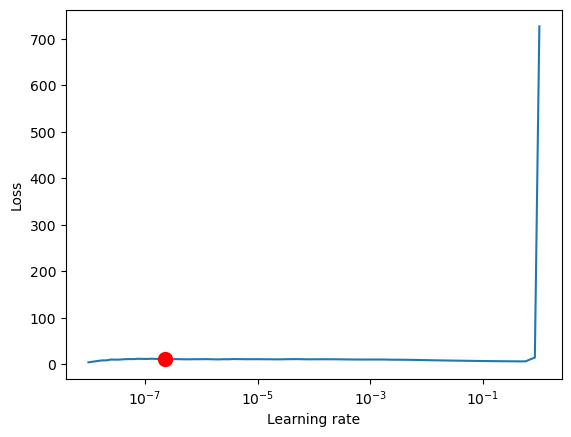

In [17]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [18]:
new_lr = lr_finder.suggestion()
model_diffusion.hparams.learning_rate = 0.01
model_diffusion.learning_rate = 0.01
#model_diffusion.hparams.learning_rate = new_lr
#model_diffusion.learning_rate = new_lr

In [22]:
trainer.fit(model_diffusion, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type          | Params
--------------------------------------------------------------
0  | coboundary_vec_out         | ParameterList | 5.0 K 
1  | coboundary_vec_in          | ParameterList | 5.0 K 
2  | graph_to_sheaf             | Linear        | 34.1 K
3  | graph_to_sheaf2            | Linear        | 420   
4  | self_energy_channel_mixing | Linear        | 20    
5  | self_energy_stalk_mixing   | Linear        | 30    
6  | diffusion_stalk_mixing     | Linear        | 30    
7  | diffusion_channel_mixing   | Linear        | 20    
8  | lin_left_weights           | ModuleList    | 75    
9  | lin_right_weights          | ModuleList    | 48    
10 | batch_norms  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


In [23]:
torch.diag(1.+5*torch.ones(3))

tensor([[6., 0., 0.],
        [0., 6., 0.],
        [0., 0., 6.]])

wandb: Network error (ReadTimeout), entering retry loop.


In [19]:
import torch
from torch_sparse import coalesce

In [23]:
index = torch.tensor([[1, 0, 1, 0, 2, 1],
                      [0, 1, 1, 1, 0, 0]])
value = torch.Tensor([1,2,3,4,5,6])

index, value = coalesce(index, value, m=3, n=2)

In [24]:
index

tensor([[0, 1, 1, 2],
        [1, 0, 1, 0]])

In [25]:
value

tensor([6., 7., 3., 5.])